In [35]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

import altair as alt
import matplotlib.pyplot as plt

In [36]:
# Get datasets

datasets = [
    "../OECD/Cleaned/HEALTH_MERGED_Threshold_80_n3.csv",
    "../WorldBankDatasets/Cleaned/AllMerged_Threshold_85_n3_MMRTNE.csv",
]
indicator = ["MATIMATM", "SH.STA.MMRT.NE"]

# Select dataset
OECD = True  # True for WB

i = 0 if OECD else 1
df = pd.read_csv(datasets[i])
mm_ind = indicator[i]

In [37]:
# Utility functions


def add_info_to_reduced(reduced, original):
    """Transformed reduced data into a dataframe and adds country and MMR info"""
    reduced = pd.DataFrame(reduced)
    reduced.columns = reduced.columns.astype(str)
    reduced["MMR"] = list(original[mm_ind])
    reduced["Country"] = list(original["Country"])

    return reduced


def viz_reduction(source, params):
    """Produces 2D chart of reduced data"""

    # Alter scale
    set_scale = [alt.Scale(), alt.Scale()]
    if params["scale"]:
        set_scale = [
            alt.Scale(domain=params["scale"]["x"]),
            alt.Scale(domain=params["scale"]["y"]),
        ]

    # Produce chart
    chart = (
        alt.Chart(source)
        .mark_circle()
        .encode(
            x=alt.X("0", title="Component 1", scale=set_scale[0]),
            y=alt.Y("1", title="Component 2", scale=set_scale[1]),
            color=alt.Color("MMR", scale=alt.Scale(scheme="reds")),
            tooltip=["Country"],
        )
        .configure_axis(grid=False)
        .properties(
            title="{} Visualization of OECD Nations using {} {} Indicators, for {}".format(
                params["method"], params["dataset"], params["theme"], params["year"]
            ),
            width=500,
            height=500,
        )
    )

    return chart

### Data Visualization using Dimensionality Reduction

The World Bank dataset contains over hundreds of indicators across a wide variety of themes, six of which we have downloaded through the World Bank API.
These visuals will focus on the indicators belonging to the theme of Gender, which includes the Maternal Mortality indicator.

In [38]:
# Look at availablity of data for the past 10 years in the dataset
df.groupby("Year").count()["Country"].tail(10)

Year
2013    41
2014    42
2015    42
2016    40
2017    38
2018    38
2019    36
2020    36
2021    28
2022     3
Name: Country, dtype: int64

For this analysis, we will limit the data to the year 2015 to be consistent with the WB modeling.

In [39]:
# Limit to specific year
year = 2015
df = df[df["Year"] == year]

# Drop year, country, and predictor
X = df.drop(columns=["Country", "Year", mm_ind])

# Set parameters for visualizations
params = {}
params["dataset"] = "OECD" if OECD else "World Bank"
params["theme"] = "Gender" if not OECD else "All"
params["year"] = year
params["scale"] = None

### PCA

In [40]:
# Run PCA explaining % of variance for 2 components
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# Print stats
print("Number of PCs: {}".format(len(pca.explained_variance_ratio_)))
print("Explained variation per PC: {}".format(pca.explained_variance_ratio_))
print("Sum of explained variation: {}".format(pca.explained_variance_ratio_.sum()))
print("\n")

Number of PCs: 2
Explained variation per PC: [0.2342396  0.15567703]
Sum of explained variation: 0.3899166258908208




In [41]:
# PCA visualization with two components
params["method"] = "PCA"
viz_reduction(add_info_to_reduced(X_pca, df), params)

alt.Chart(...)

### T-SNE

T-SNE is another method of dimensionality reduction that is able to work effectively with non-linear data. Here, we attempt to use T-SNE to see if it can help find structure where PCA did not.

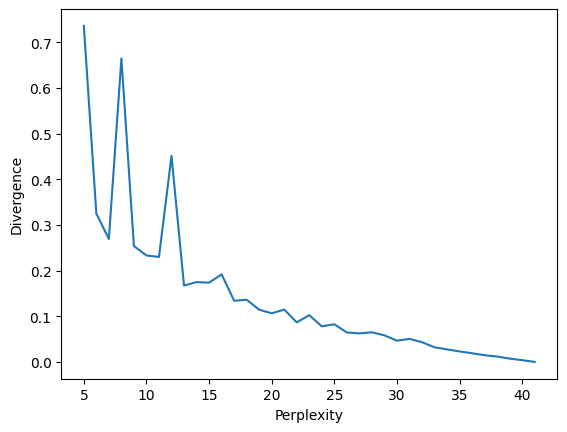

In [42]:
# One of the main methods of tuning T-SNE is through the perplexity parameter
# Here, we test different perplexity values and use KL Divergence as a heuristic to find the best value

score = []
for p in np.arange(5, X.shape[0]):
    tsne = TSNE(n_components=2, perplexity=p, random_state=42)
    tsne.fit_transform(X)
    score.append(tsne.kl_divergence_)

plt.plot(np.arange(5, X.shape[0]), score)
plt.xlabel("Perplexity")
plt.ylabel("Divergence")
plt.show()

In [43]:
# Run T-SNE for 2 components, using suggested perplexity
tsne = TSNE(n_components=2, perplexity=40, random_state=42)
X_tsne = tsne.fit_transform(X)

In [44]:
# T-SNE visualization with two components
params["method"] = "T-SNE"
params["scale"] = {"x": [1.6, 3], "y": [-6, -4]}
viz_reduction(add_info_to_reduced(X_tsne, df), params)

alt.Chart(...)

# UMAP

With the T-SNE results showing promise, we will also test a similar dimensionality reduction technique known as UMAP, which offers several advantages over T-SNE or PCA.

In [45]:
# UMAP Exploration

# Code from https://umap-learn.readthedocs.io/en/latest/parameters.html

data = X


def draw_umap(
    n_neighbors=3, min_dist=0.1, n_components=2, metric="euclidean", title=""
):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        random_state=42,
        metric=metric,
    )
    u = fit.fit_transform(data)
    fig = plt.figure()

    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:, 0], u[:, 1])

    plt.title(title, fontsize=18)

/home/smonem/MADS_MilestoneII/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/smonem/MADS_MilestoneII/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/smonem/MADS_MilestoneII/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/smonem/MADS_MilestoneII/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden

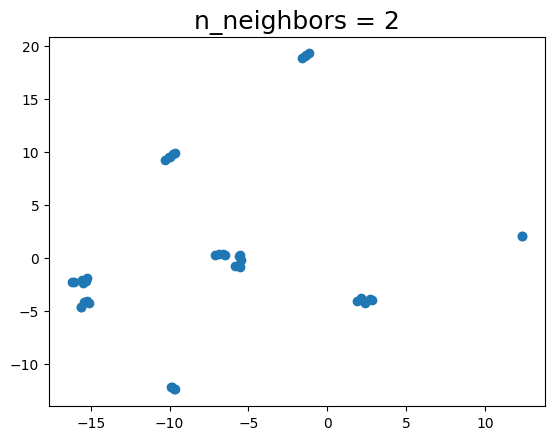

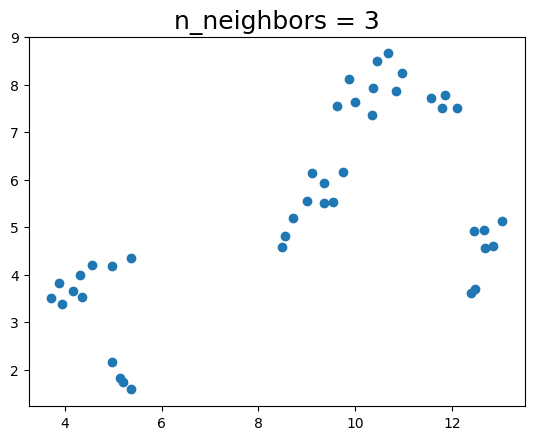

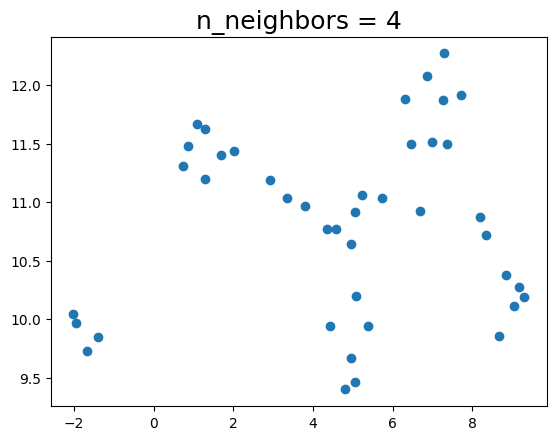

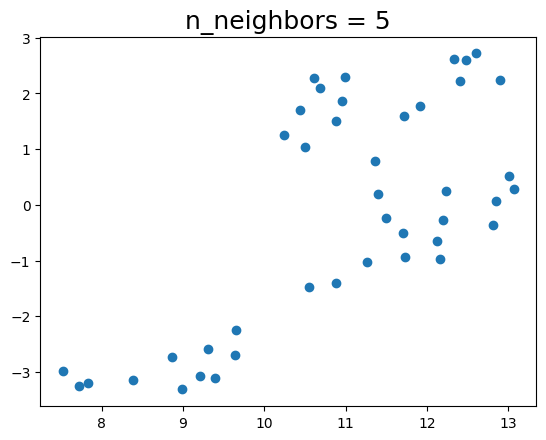

In [46]:
for n in (2, 3, 4, 5):
    draw_umap(n_neighbors=n, title="n_neighbors = {}".format(n))

/home/smonem/MADS_MilestoneII/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/smonem/MADS_MilestoneII/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/smonem/MADS_MilestoneII/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/smonem/MADS_MilestoneII/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden

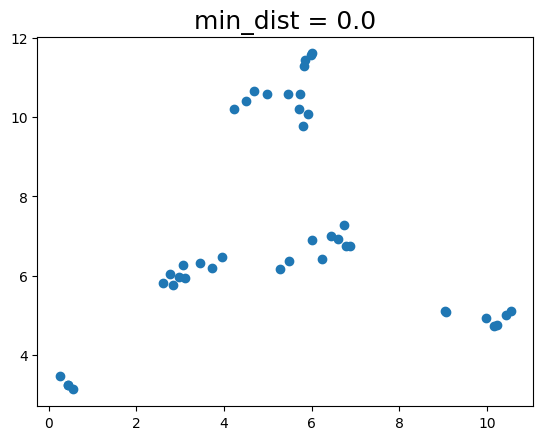

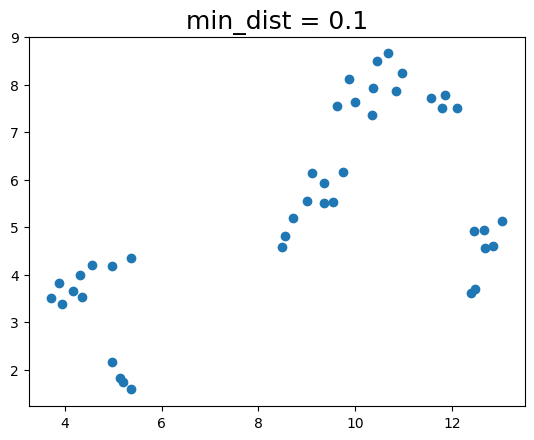

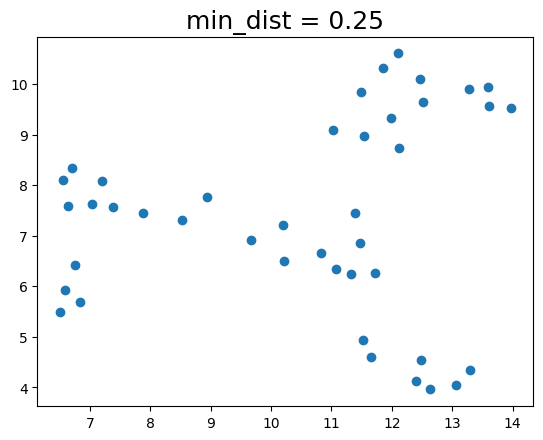

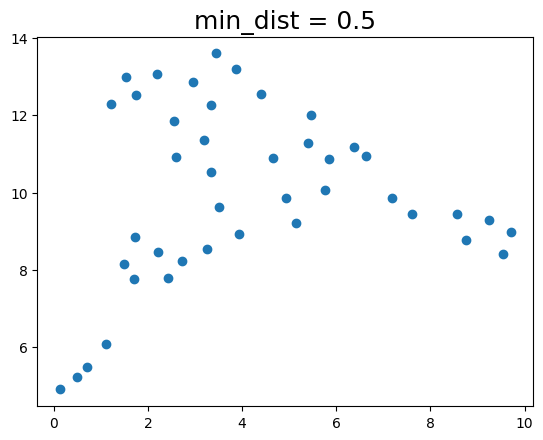

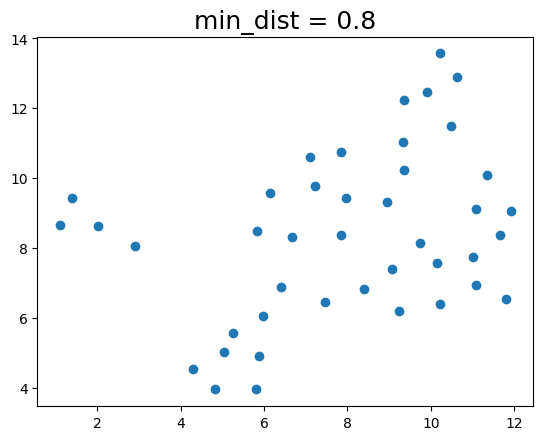

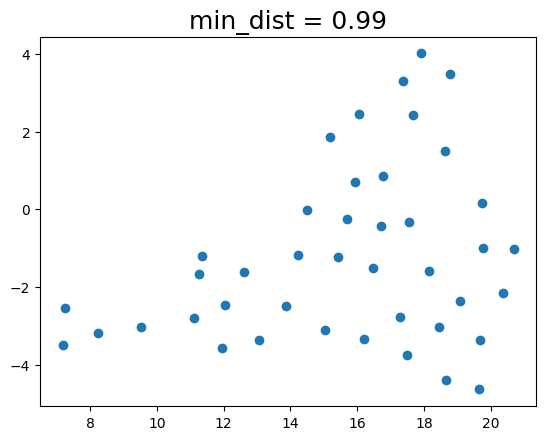

In [47]:
for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
    draw_umap(min_dist=d, title="min_dist = {}".format(d))

In [52]:
# UMAP visualization with two embeddings
embeddings = umap.UMAP(
    n_components=2, n_neighbors=3, min_dist=0.1, random_state=42
).fit_transform(X)

params["method"] = "UMAP"
params["scale"] = None
viz_reduction(add_info_to_reduced(embeddings, df), params)

/home/smonem/MADS_MilestoneII/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


alt.Chart(...)